In [17]:
library(tidyverse)
library(limma)
library(data.table)
library(UpSetR)

# Load data

In [18]:
metadata <- read.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Metadata_CosyBio.tsv",
                       header = TRUE, sep = "\t", stringsAsFactors = FALSE)
                       
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(".Pool", ".P_", gsub("Reporter.intensity.corrected.", "RIC_", Quantitative.column.name)))


# remove the outlier
metadata <- metadata %>%
            filter(Quantitative.column.name != "RIC_3.P_3")


# rename the columns - put the .P_[1-9]+ after dot before and the rest after (e.g. RIC_1.P_1 -> P_1.RIC_1)
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub("RIC_([0-9]+).P_([0-9]+)", "P_\\2.RIC_\\1", Quantitative.column.name))


head(metadata, 3)
dim(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
Reporter.intensity.corrected.3.Pool1,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1


[1] 65  6

In [19]:
preprocess_mxout <- function(path, center_metadata, center){
    PG_report <- read.table(
        path,
        header=T,
        sep="\t",
        stringsAsFactors = F)
    
    # remove decoy matches and matches to contaminant
    # PG_report <- PG_report[!PG_report$Reverse=="+",]
    # PG_report <- PG_report[!PG_report$Potential.contaminant=="+",]
    # # if the PG_report$Only.identified.by.site is not all NA and contains "+" values - remove this rows
    # if(!all(is.na(PG_report$Only.identified.by.site))) {
    #     # # Only.identified.by.site - exclude proteins that were only identified by a modification site
    #     PG_report <- PG_report[!PG_report$Only.identified.by.site=="+",]
    # }

    print(center)
    # take only the columns that we need
    pg_intensities <- PG_report %>%
        select(c("Sequence", "Proteins", "Leading.razor.protein", "Gene.names", "Protein.names", rownames(center_metadata)))

    print(length(pg_intensities$Sequence))

    # counts
    # pg_counts <- PG_report %>%
    #     select(c("Majority.protein.IDs", "Razor...unique.peptides")) 
    # rownames(pg_counts) <- pg_counts$Majority.protein.IDs
    # pg_counts$Majority.protein.IDs <- NULL
    # pg_counts <- pg_counts + 1
    # return(list(pg_intensities, pg_counts))
    return(pg_intensities)
}

In [20]:
# list_of_outputs <- list(
#     "Center1" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center1.txt",
#     "Center2" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center2.txt",
#     "Center3" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center3.txt"
# )

list_of_outputs <- list(
    "Center1" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Center1/peptides.txt",
    "Center2" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Center2/peptides.txt",
    "Center3" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Center3/peptides.txt"
)

#"Peptide.sequences", "Peptide.IDs"

combined_pg_intensities <- list()

for(center in names(list_of_outputs)) {

    center_metadata <- metadata %>%
        filter(Center == center)

    results_list <- preprocess_mxout(list_of_outputs[[center]], center_metadata, center)
    # pg_intensities <- results_list[[1]]
    # counts_df <- results_list[[2]]
    pg_intensities <- results_list

    pg_intensities <- pg_intensities[, c("Sequence", "Gene.names", rownames(center_metadata))]
    colnames(pg_intensities) <- c("Sequence", "Gene.names", center_metadata$Quantitative.column.name)
    
    combined_pg_intensities <- c(combined_pg_intensities, list(pg_intensities))
}

names(combined_pg_intensities) <- names(list_of_outputs)

rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
    mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))


[1] "Center1"
[1] 5958
[1] "Center2"
[1] 6303
[1] "Center3"
[1] 5528


In [21]:
pg_one <- unique(combined_pg_intensities[["Center1"]]$Sequenc)
length(pg_one)

pg_two <- unique(combined_pg_intensities[["Center2"]]$Sequence)
length(pg_two)

pg_three <- unique(combined_pg_intensities[["Center3"]]$Sequence)
length(pg_three)

common_proteins <- intersect(pg_one, pg_two) %>% intersect(pg_three)
length(common_proteins)

[1] 5958

[1] 6303

[1] 5528

[1] 4258

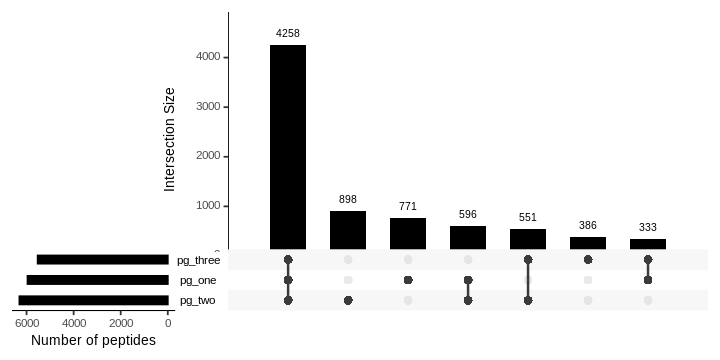

In [22]:
all_elements <- unique(c(pg_one, pg_two, pg_three))

data <- data.frame(element = all_elements,
                   pg_one = as.integer(all_elements %in% pg_one),
                   pg_two = as.integer(all_elements %in% pg_two),
                   pg_three = as.integer(all_elements %in% pg_three))

options(repr.plot.width=6, repr.plot.height=3)
upset(data, sets = c("pg_one", "pg_two", "pg_three"), order.by = "freq",
        # add title to the whole plot

        main.bar.color = "black",
        sets.bar.color = "black",
        sets.x.label = "Number of peptides",
        )

In [8]:
for(seq in all_elements) {
  if(grepl("[^ARNDCEQGHILKMFPSTWYV]", seq)) {
    print(seq)
  }
}

In [89]:
length(unique(combined_pg_intensities$Gene.names))

[1] 403

In [16]:
dim(combined_pg_intensities[["Center1"]])
head(combined_pg_intensities[["Center1"]])

[1] 5958   24

,Sequence,Gene.names,P_1.RIC_1,P_1.RIC_2,P_1.RIC_3,P_1.RIC_4,P_1.RIC_5,P_1.RIC_6,P_1.RIC_7,P_1.RIC_8,⋯,P_2.RIC_2,P_2.RIC_3,P_2.RIC_4,P_2.RIC_5,P_2.RIC_6,P_2.RIC_7,P_2.RIC_8,P_2.RIC_9,P_2.RIC_10,P_2.RIC_11
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AAAATGTIFTFR,SERPINA5;SERPINA3,9932.8,10121.0,10191.0,4770.3,8109.8,12217.0,12637.0,7853.4,⋯,11449.0,13269.0,10432.0,11303,11982.0,13611.0,10683,17423.0,13646.0,10668.0
2,AAAEVAGQFVIK,TFRC,10290.0,12784.0,10758.0,11639.0,28589.0,8405.1,9419.1,11465.0,⋯,4772.9,5934.7,6579.4,30413,7230.7,6592.5,5579,6804.8,6110.1,8226.6
3,AAAPNTPK,PRG4,17777.0,9563.2,9668.6,7848.9,17987.0,10502.0,10021.0,8529.6,⋯,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0
4,AAASIVKVPVFKTETK,,9882.7,15669.0,9324.0,7593.7,6096.4,12475.0,9141.1,9929.8,⋯,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0
5,AAATGPSFWLGNETLK,PEPD,7181.6,17860.0,11005.0,17886.0,6825.8,12991.0,8116.2,12296.0,⋯,31181.0,30462.0,46440.0,22811,39373.0,30387.0,33787,34569.0,31633.0,29895.0
6,AACAQLNDFLQEYGTQGCQV,C4A;C4B,33053.0,29779.0,32953.0,29134.0,28264.0,30284.0,35200.0,18216.0,⋯,26538.0,27203.0,31319.0,32107,30415.0,33446.0,32817,32809.0,32191.0,36526.0


In [80]:
head(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
P_1.RIC_1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
P_1.RIC_2,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
P_1.RIC_3,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1
P_1.RIC_4,P_1.RIC_4,Pool1,128N,heathy2,heathy,Center1
P_1.RIC_5,P_1.RIC_5,Pool1,128C,FSGS2,FSGS,Center1
P_1.RIC_6,P_1.RIC_6,Pool1,129N,heathy3,heathy,Center1


In [81]:
meta_data <- metadata %>% as.data.table()
prot_data <- combined_pg_intensities %>% as.data.table()


In [82]:
# Replace all 0s with NAs in specified columns of prot_data
prot_data[, (meta_data$Quantitative.column.name) := lapply(.SD, function(x) { ifelse(x == 0, NA, x) }), .SDcols = meta_data$Quantitative.column.name]

In [101]:
filter_na_proteins <- function(dt, meta_data) {
    # Filter out proteins that have NAs in all columns
    dt <- dt[!rowSums(is.na(dt[, (meta_data$Quantitative.column.name), with = FALSE])) == length(meta_data$Quantitative.column.name)]
    return(dt)
}

cat('Before filtering:', dim(prot_data), '\n')
prot_data <- filter_na_proteins(prot_data, meta_data)
cat('After filtering:', dim(prot_data), '\n')

Before filtering: 3720 67 
After filtering: 3720 67 


# plots

In [21]:
pca_plot <- function(df, batch_info, title, path, quantitative_col_name = "Quantitative.column.name", col_col = "Group", shape_col = "Center") {
  pca <- prcomp(t(na.omit(df)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column(quantitative_col_name) %>% 
    left_join(batch_info, by = quantitative_col_name)
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_plot <- pca_df %>%
    ggplot(aes_string(x = "PC1", y = "PC2", color = col_col, shape = shape_col)) + # Note: aes_string is deprecated, consider using aes() with !!sym() for newer versions
    geom_point(size=3) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if (path == "") {
    return(pca_plot)
  } else {
    ggsave(path, pca_plot, width = 5, height = 5)
    return(pca_plot)
  }
}


# boxplot
boxplot_pg <- function(protein_matrix, title, path) {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "file", value = "Intensity")
  # Log tranformed scale
  boxplot <- ggplot(long_data, aes(x = file, y = Intensity)) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 3, color = "red") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    # adjust fonsize for the x-axis
    theme(axis.text.x = element_text(size = 8)) +
    labs(title = title) 

  if(path == "") {
    return(boxplot)
  } else {
      ggsave(path, boxplot)
      return(boxplot)
  }

}



In [22]:
# set size of the plots
options(repr.plot.width=6, repr.plot.height=5)

# before

Warning message:
“Removed 432 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 432 rows containing non-finite values (`stat_summary()`).”


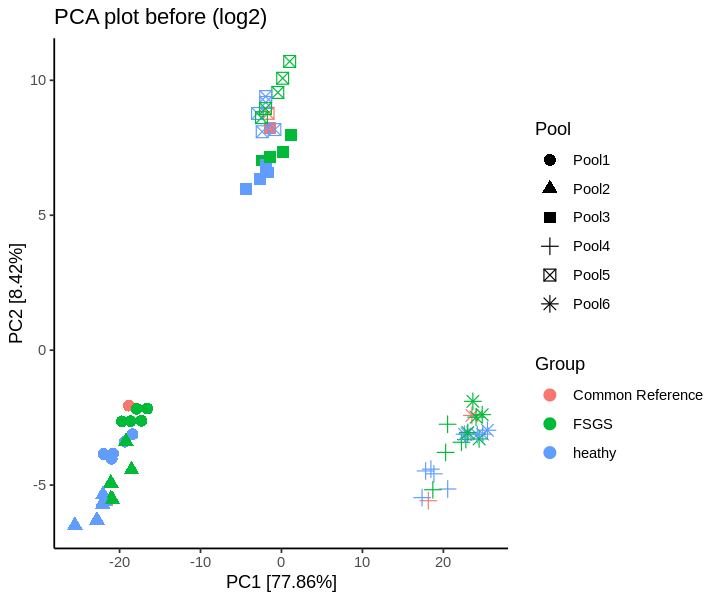

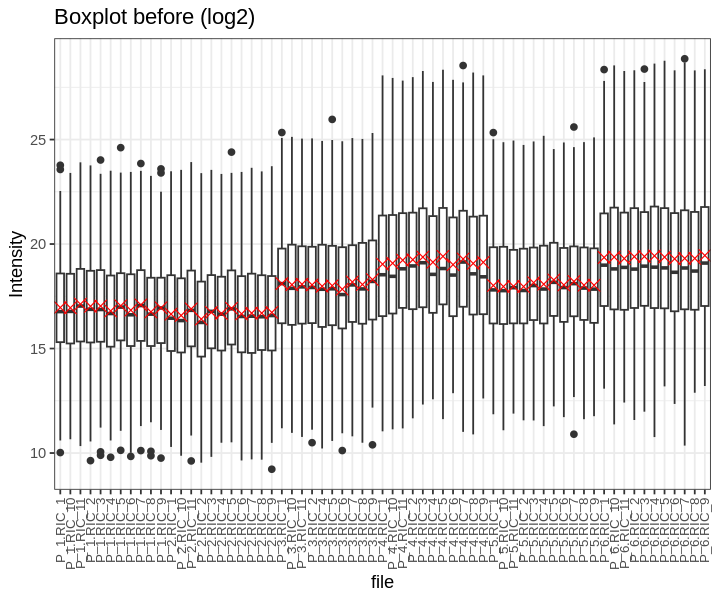

In [23]:
# plot PCA
pca_plot(log2(prot_data[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot before (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_before <- pca_plot(log2(prot_data[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot before (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log2(prot_data[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot before (log2)", "")
boxplot_before <- boxplot_pg(log2(prot_data[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot before (log2)", "")

# Median norm

In [24]:
# ffrom PRONE.R

medianNorm <- function(dt, metadata){
  # find median of each sample
  sample_med <- apply(dt, 2, stats::median, na.rm=TRUE) # columns
  # find mean of medians
  mean_med <- mean(sample_med, na.rm=TRUE)
  # divide data by median
  norm_dt <- t(t(dt)/sample_med)
  # multiply data by mean of medians
  norm_dt <- norm_dt * mean_med
  norm_dt <- data.table::as.data.table(norm_dt)
  colnames(norm_dt) <- colnames(dt)
  rownames(norm_dt) <- rownames(dt)
  return(norm_dt)
}

Warning message:
“Removed 432 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 432 rows containing non-finite values (`stat_summary()`).”


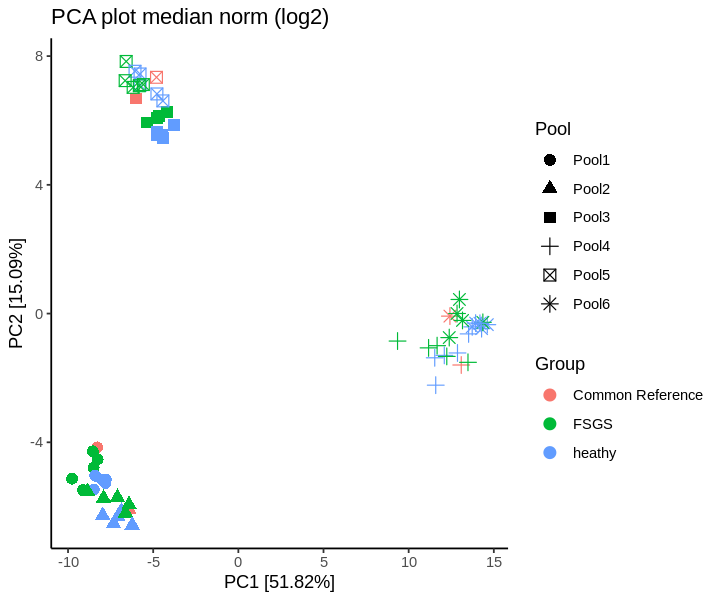

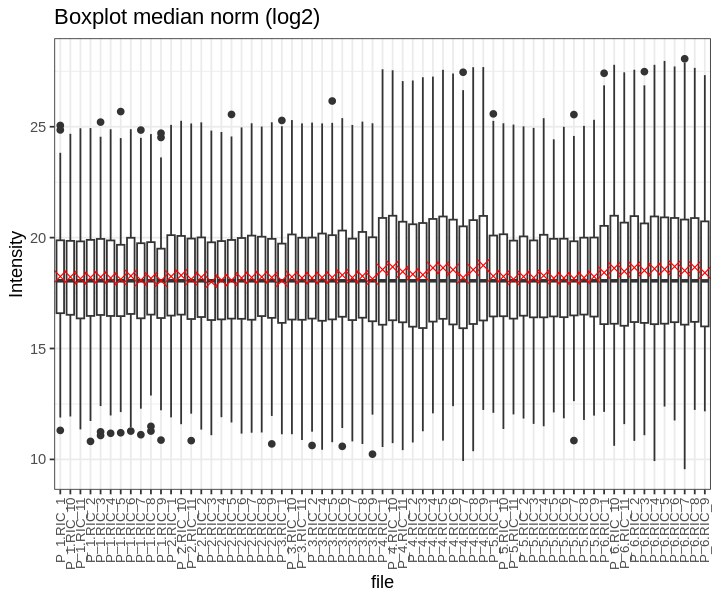

In [25]:
median <- medianNorm(prot_data[, -c("Majority.protein.IDs", "Gene.names")], meta_data)
# add back the Majority.protein.IDs and Gene.names
median <- cbind(prot_data[, c("Majority.protein.IDs", "Gene.names")], median)

# plot PCA
pca_plot(log2(median[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_median <- pca_plot(log2(median[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot median norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")


# plot boxplot
boxplot_pg(log2(median[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot median norm (log2)", "")
boxplot_median <- boxplot_pg(log2(median[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot median norm (log2)", "")

# IRS

In [26]:
irsNorm <- function(dt, md, batch, refs){
  # get md of reference samples
  refs_md <- md[md$Quantitative.column.name %in% refs,]
# separate data by batch
  dt_list <- lapply(unique(md[["Pool"]]), function(b){
      md_chunk <- md[md[["Pool"]] == b,]
      dt_chunk <- subset(dt, select = md_chunk$Quantitative.column.name)
      return(dt_chunk)
  })
  names(dt_list) <- unique(md[["Pool"]])
  
  # take reference sample intensities
  irs <- subset(dt, select = refs_md$Quantitative.column.name)
  colnames(irs) <- as.character(refs_md[refs_md$Quantitative.column.name %in% refs,][["Pool"]])
  
  # get the geometric average intensity for each protein
  irs <- tibble::as_tibble(irs)
  irs$average <- apply(irs, 1, function(x) exp(mean(log(x), na.rm=TRUE)))
  # normalize data
  dt_irs_list <- lapply(names(dt_list), function(b){
    # compute scaling factor vectors
    fac <- irs$average / irs[,b]
    # normalize
    dt_irs_chunk <- dt_list[[b]] * fac[,1]
    return(dt_irs_chunk)
  })
  # reconstruct data after irs normalization
  dt_irs <- do.call(cbind, dt_irs_list)
  dt_irs <- data.table::as.data.table(dt_irs)
  dt_irs <- subset(dt_irs, select = colnames(dt))
  
  return(dt_irs)
}

Warning message:
“Removed 436 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 436 rows containing non-finite values (`stat_summary()`).”


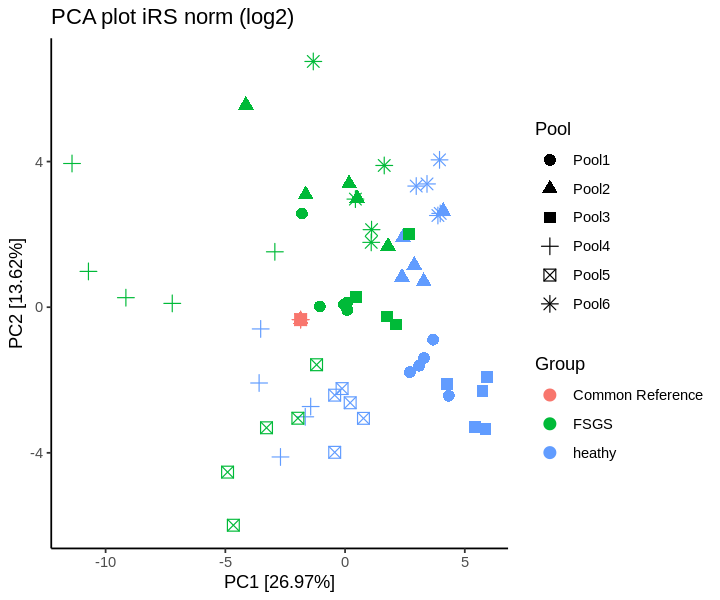

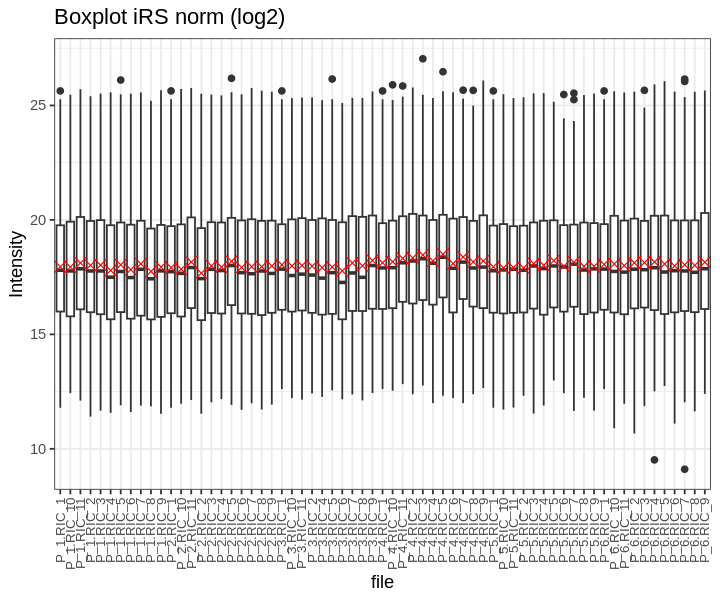

In [27]:
ref_samples <- meta_data[meta_data$Group == 'Common Reference',]$Quantitative.column.name
batch <- meta_data$Pool

# iRS on raw data
irs <- irsNorm(prot_data[, -c("Majority.protein.IDs", "Gene.names")], meta_data, batch, ref_samples)
# add back the Majority.protein.IDs and Gene.names
irs <- cbind(prot_data[, c("Majority.protein.IDs", "Gene.names")], irs)

# plot PCA
pca_plot(log2(irs[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_irs <- pca_plot(log2(irs[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log2(irs[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot iRS norm (log2)", "")
boxplot_irs <- boxplot_pg(log2(irs[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot iRS norm (log2)", "")


# iRS on median

Warning message:
“Removed 436 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 436 rows containing non-finite values (`stat_summary()`).”


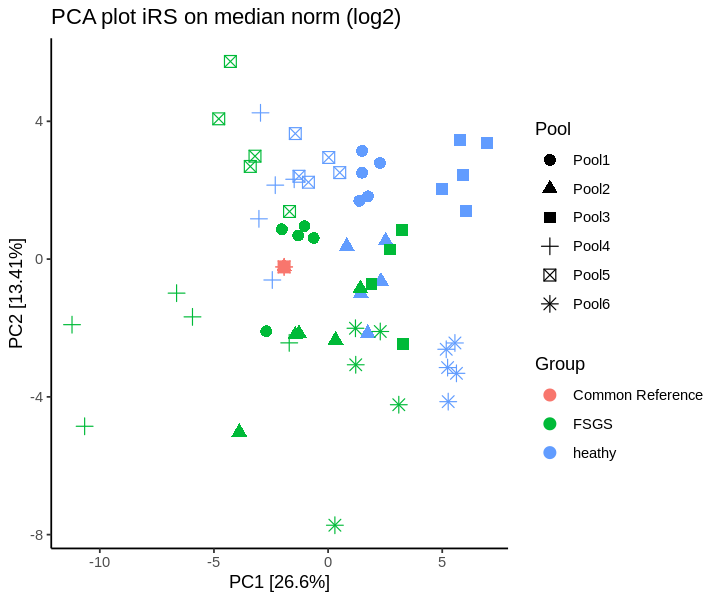

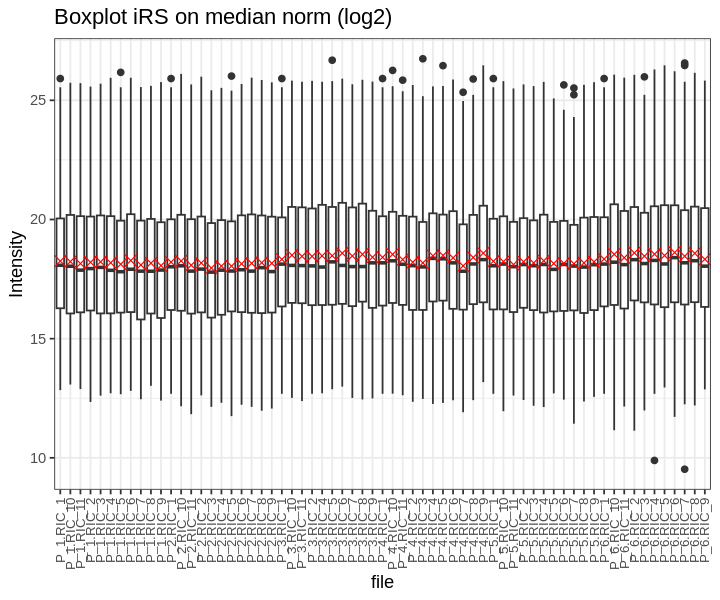

In [28]:
irs_on_median <- irsNorm(median[, -c("Majority.protein.IDs", "Gene.names")], meta_data, batch, ref_samples)
# add back the Majority.protein.IDs and Gene.names
irs_on_median <- cbind(median[, c("Majority.protein.IDs", "Gene.names")], irs_on_median)

# plot PCA
pca_plot(log2(irs_on_median[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS on median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_irs_on_median <- pca_plot(log2(irs_on_median[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS on median norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log2(irs_on_median[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot iRS on median norm (log2)", "")
boxplot_irs_on_median <- boxplot_pg(log2(irs_on_median[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot iRS on median norm (log2)", "")


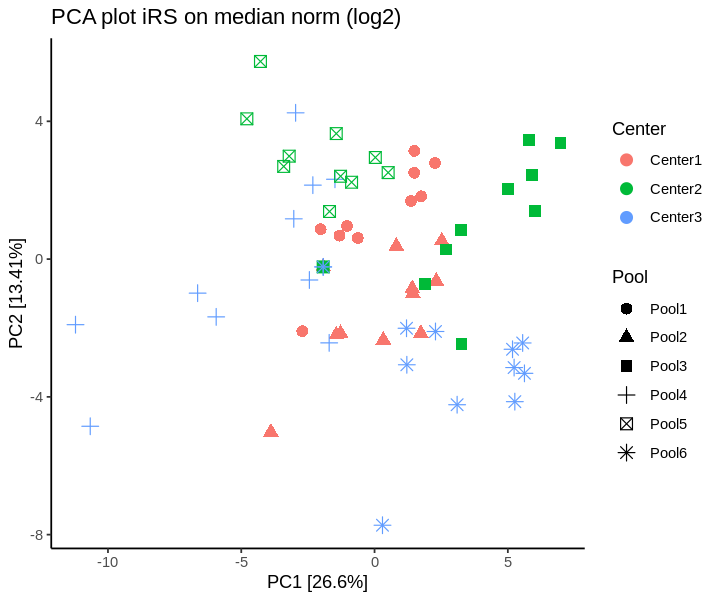

In [29]:
# plot PCA
pca_plot(log2(irs_on_median[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS on median norm (log2)", "",
         "Quantitative.column.name", col_col = "Center", shape_col = "Pool")


# Median on iRS

Warning message:
“Removed 436 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 436 rows containing non-finite values (`stat_summary()`).”


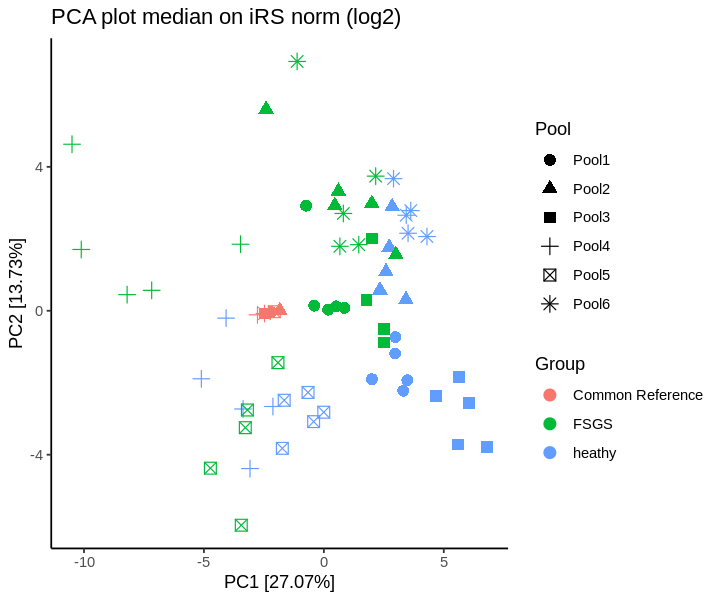

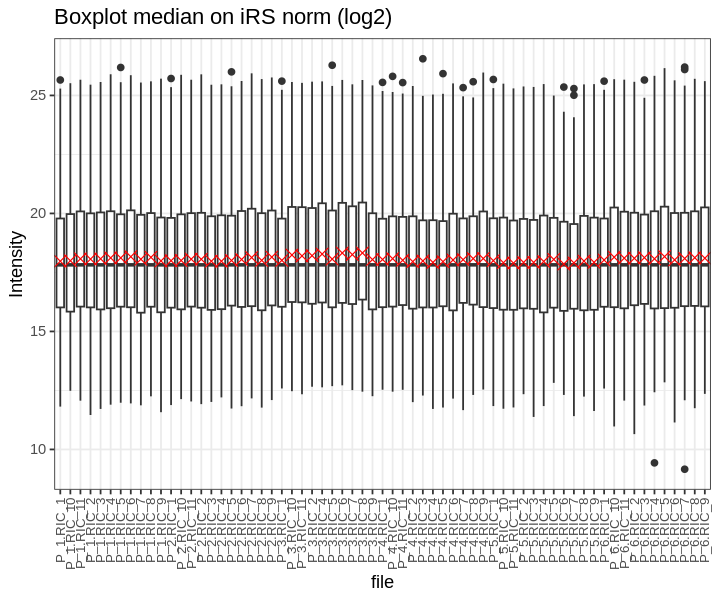

In [31]:
median_on_irs <- medianNorm(irs[, -c("Majority.protein.IDs", "Gene.names")], meta_data)
# add back the Majority.protein.IDs and Gene.names
median_on_irs <- cbind(irs[, c("Majority.protein.IDs", "Gene.names")], median_on_irs)

# plot PCA
pca_plot(log2(median_on_irs[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot median on iRS norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log2(median_on_irs[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot median on iRS norm (log2)", "")

# IRS_on_log_median

Warning message:
“Removed 432 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 432 rows containing non-finite values (`stat_summary()`).”


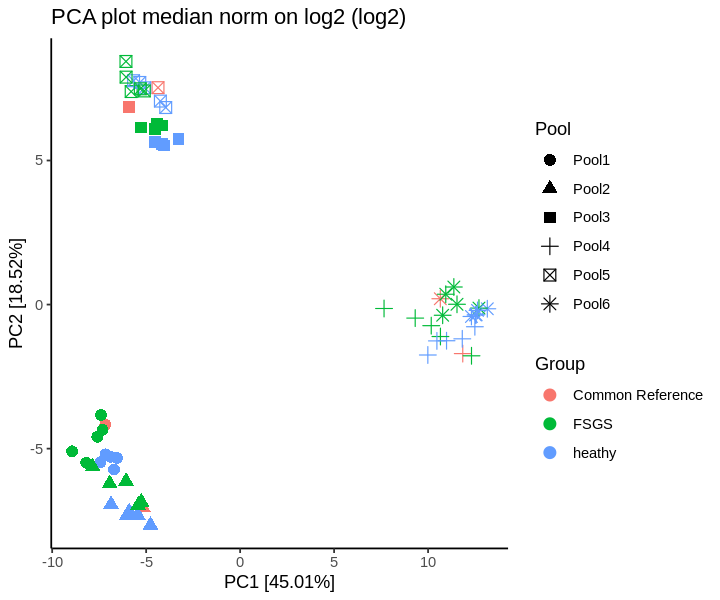

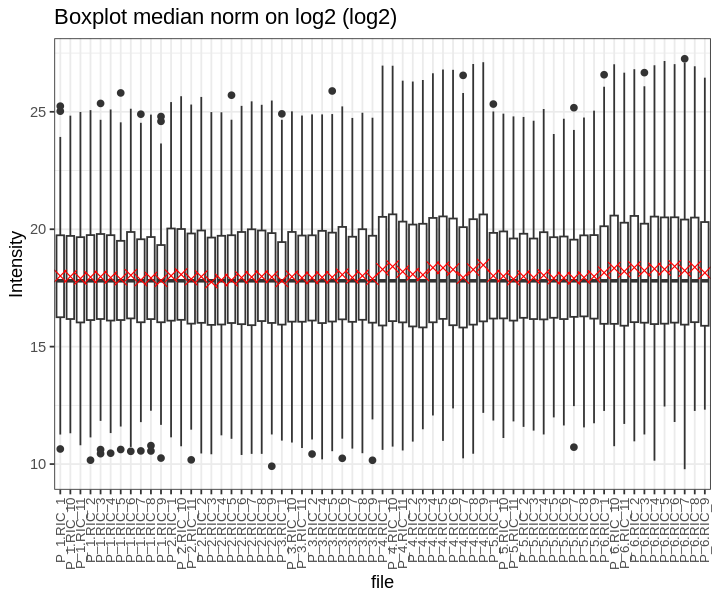

In [32]:
# do median normalization on log2 transformed raw data
log_median <- medianNorm(log2(prot_data[, -c("Majority.protein.IDs", "Gene.names")]+1), meta_data)
# add back the Majority.protein.IDs and Gene.names
log_median <- cbind(prot_data[, c("Majority.protein.IDs", "Gene.names")], log_median)

# plot PCA
pca_plot(log_median[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot median norm on log2 (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log_median[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot median norm on log2 (log2)", "")

Warning message:
“Removed 436 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 436 rows containing non-finite values (`stat_summary()`).”


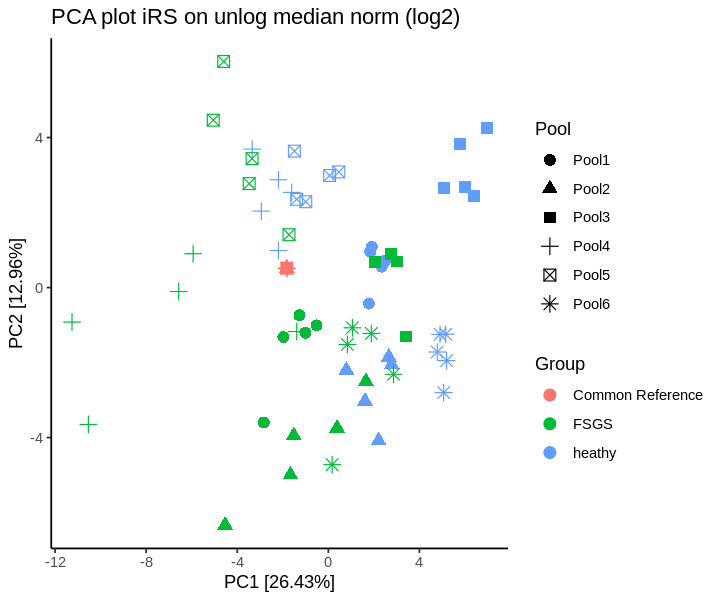

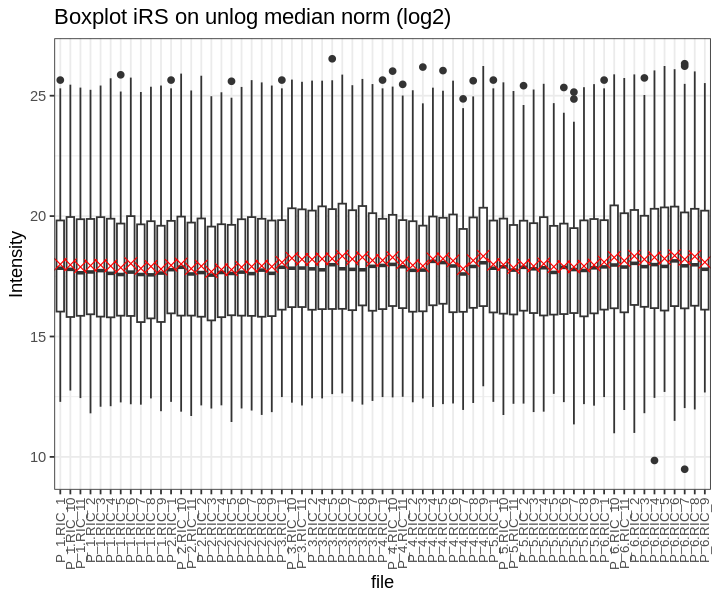

In [35]:
# irs on unlog median log
# first unlog medain log
unlog_median <- 2^medianNorm(log2(prot_data[, -c("Majority.protein.IDs", "Gene.names")]+1), meta_data)
# fo irs on unlog median log
irs_on_log_median <- irsNorm(unlog_median, meta_data, batch, ref_samples)
# add back the Majority.protein.IDs and Gene.names
irs_on_log_median <- cbind(log_median[, c("Majority.protein.IDs", "Gene.names")], irs_on_log_median)

# plot PCA
pca_plot(log2(irs_on_log_median[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS on unlog median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log2(irs_on_log_median[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot iRS on unlog median norm (log2)", "")

# log_median_on_iRS

Warning message:
“Removed 436 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 436 rows containing non-finite values (`stat_summary()`).”


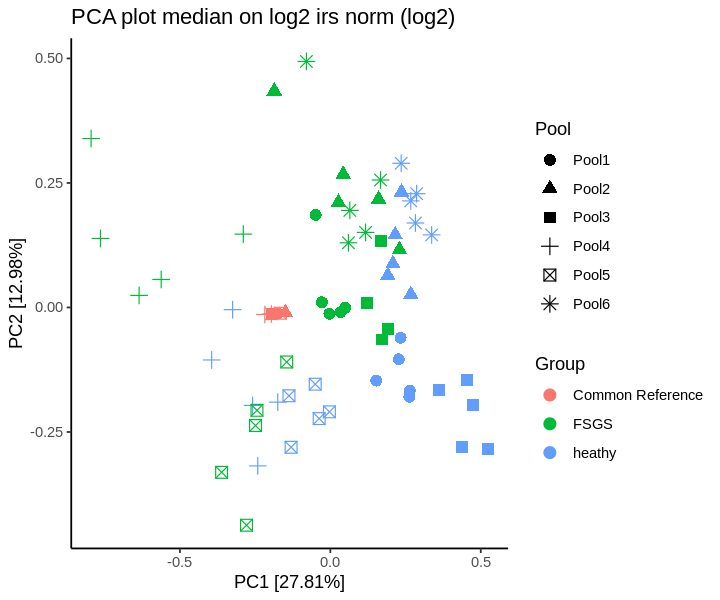

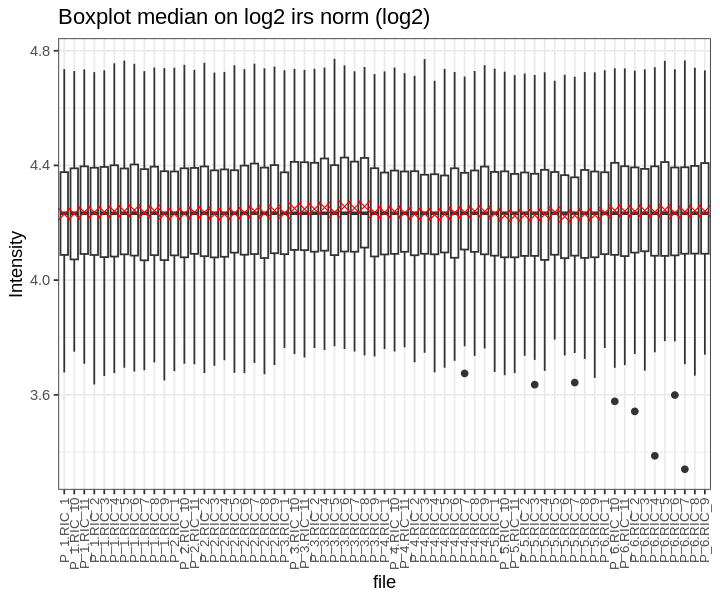

In [36]:
# median on log2 irs
log_median_on_irs <- medianNorm(log2(irs[, -c("Majority.protein.IDs", "Gene.names")]+1), meta_data)
# add back the Majority.protein.IDs and Gene.names
log_median_on_irs <- cbind(irs[, c("Majority.protein.IDs", "Gene.names")], log_median_on_irs)

# plot PCA
pca_plot(log2(log_median_on_irs[, -c("Majority.protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot median on log2 irs norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log2(log_median_on_irs[, -c("Majority.protein.IDs", "Gene.names")]+1), "Boxplot median on log2 irs norm (log2)", "")

# Remove BE limma

In [37]:
# bacth effects correction

design <- model.matrix(~0 + meta_data$Group)
head(design)

batch <- meta_data$Pool

,meta_data$GroupCommon Reference,meta_data$GroupFSGS,meta_data$Groupheathy
1,1,0,0
2,0,0,1
3,0,1,0
4,0,0,1
5,0,1,0
6,0,0,1


## on raw data

Warning message:
“Partial NA coefficients for 25 probe(s)”


Warning message:
“Removed 432 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 432 rows containing non-finite values (`stat_summary()`).”


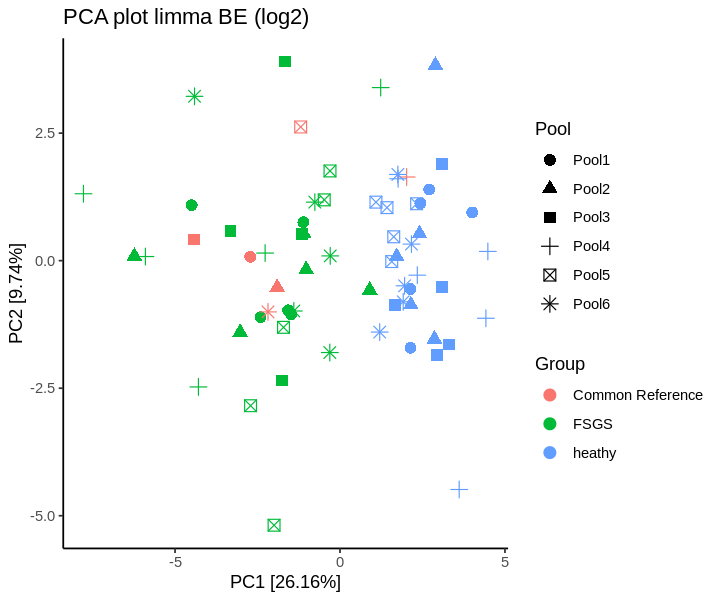

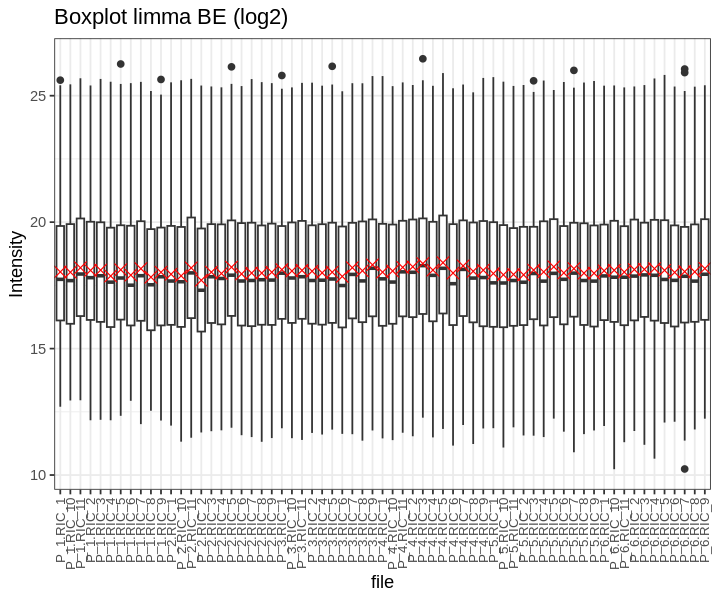

In [481]:


limBE <- limma::removeBatchEffect(log2(prot_data[, -c("Majority.protein.IDs", "Gene.names")]), batch, design = design)
# add back the Majority.protein.IDs and Gene.names
limBE <- cbind(prot_data[, c("Majority.protein.IDs", "Gene.names")], limBE)


# plot PCA
pca_plot(limBE[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

pca_limBE <- pca_plot(limBE[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(limBE[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot limma BE (log2)", "")
boxplot_limBE <- boxplot_pg(limBE[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot limma BE (log2)", "")


## on median norm data

Warning message:
“Partial NA coefficients for 25 probe(s)”


Warning message:
“Removed 432 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 432 rows containing non-finite values (`stat_summary()`).”


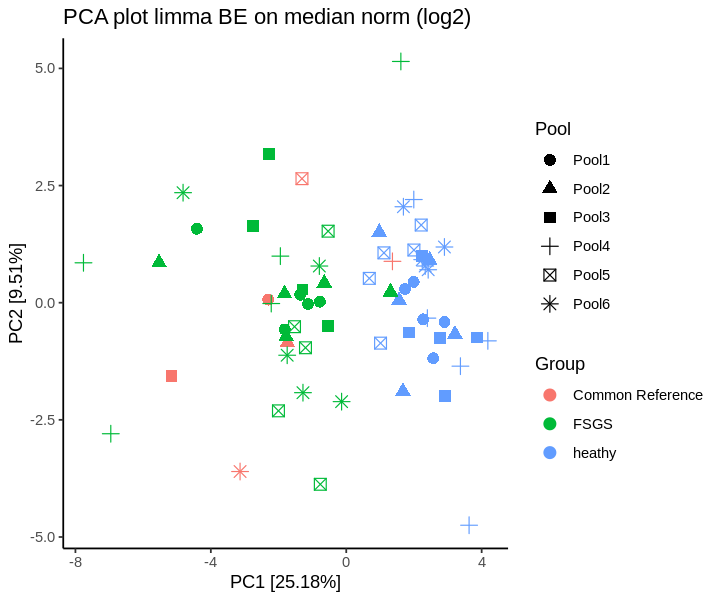

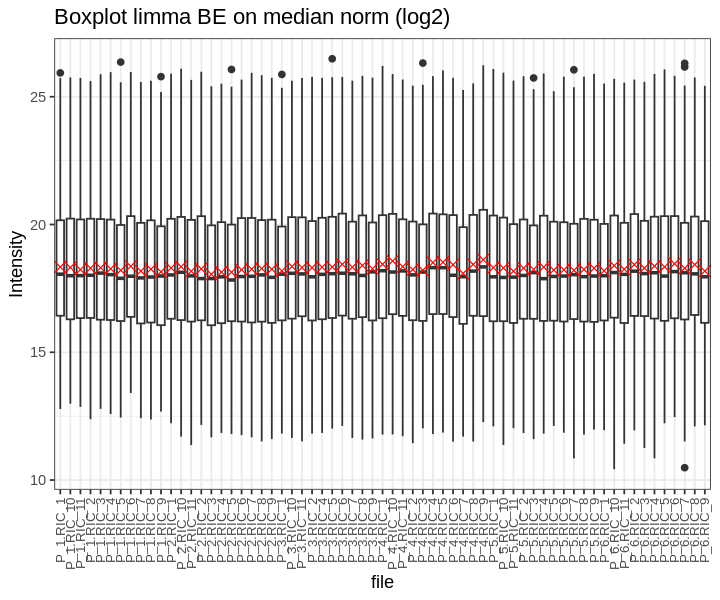

In [482]:


limBE_median <- limma::removeBatchEffect(log2(median[, -c("Majority.protein.IDs", "Gene.names")]), batch, design = design)
# add back the Majority.protein.IDs and Gene.names
limBE_median <- cbind(median[, c("Majority.protein.IDs", "Gene.names")], limBE_median)

# plot PCA
pca_plot(limBE_median[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_limBE_median <- pca_plot(limBE_median[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on median norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
    

# plot boxplot
boxplot_pg(limBE_median[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot limma BE on median norm (log2)", "")
boxplot_limBE_median <- boxplot_pg(limBE_median[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot limma BE on median norm (log2)", "")

## on irs_on_median data

Warning message:
“Partial NA coefficients for 26 probe(s)”


Warning message:
“Removed 436 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 436 rows containing non-finite values (`stat_summary()`).”


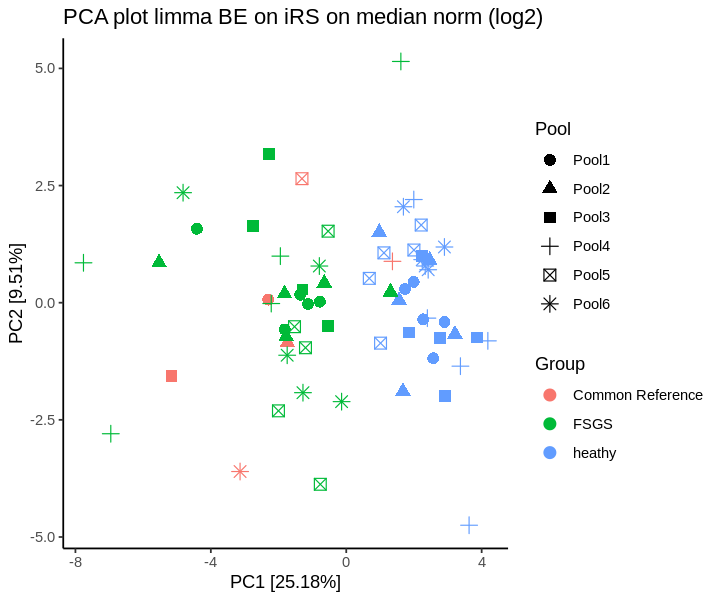

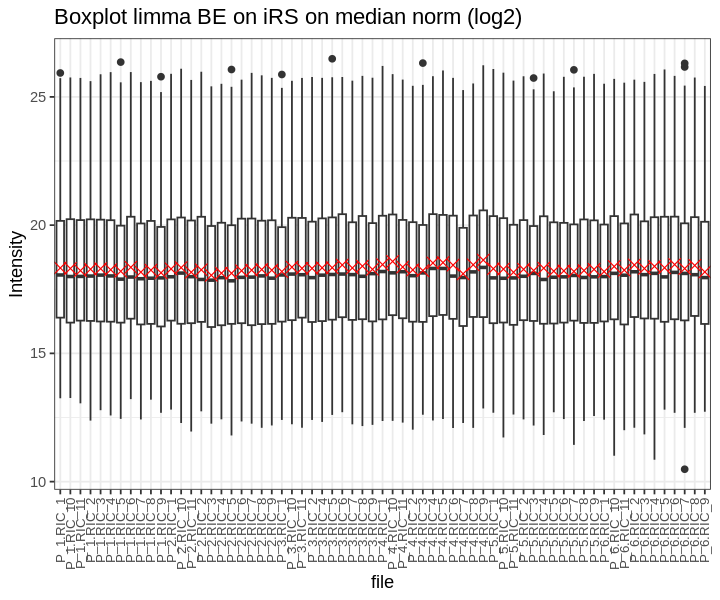

In [483]:
## on irs_on_median data
limBE_on_irs_on_median <- limma::removeBatchEffect(log2(irs_on_median[, -c("Majority.protein.IDs", "Gene.names")]), batch, design = design)
# add back the Majority.protein.IDs and Gene.names
limBE_on_irs_on_median <- cbind(irs_on_median[, c("Majority.protein.IDs", "Gene.names")], limBE_on_irs_on_median)

# plot PCA
pca_plot(limBE_on_irs_on_median[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on iRS on median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_limBE_on_irs_on_median <- pca_plot(limBE_on_irs_on_median[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on iRS on median norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(limBE_on_irs_on_median[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot limma BE on iRS on median norm (log2)", "")
boxplot_limBE_on_irs_on_median <- boxplot_pg(limBE_on_irs_on_median[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot limma BE on iRS on median norm (log2)", "")

## on medain on irs

Warning message:
“Partial NA coefficients for 26 probe(s)”


Warning message:
“Removed 436 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 436 rows containing non-finite values (`stat_summary()`).”


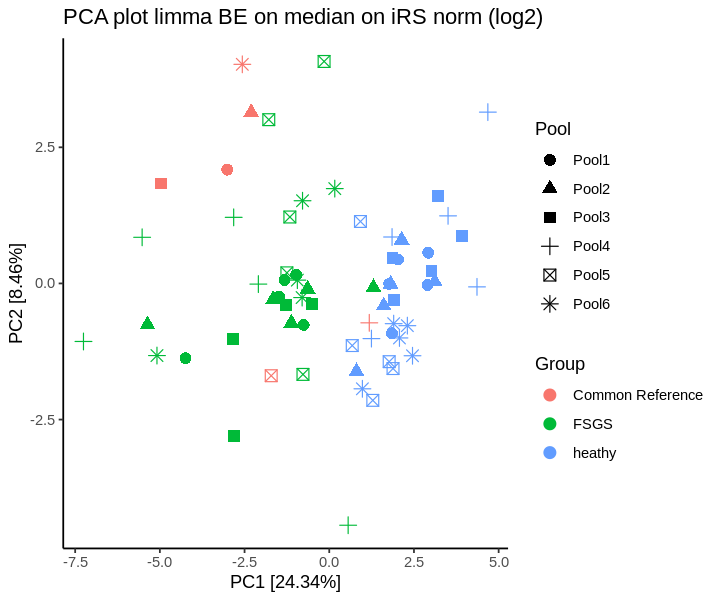

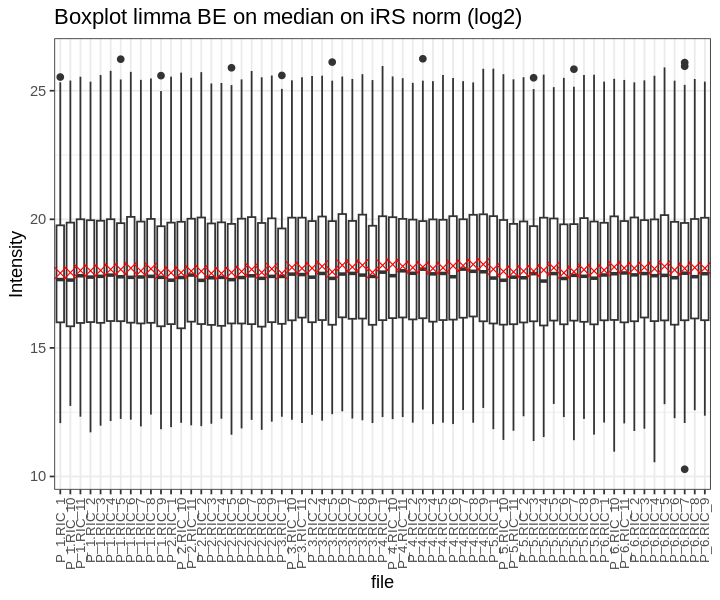

In [42]:
limma_on_median_on_irs <- limma::removeBatchEffect(log2(median_on_irs[, -c("Majority.protein.IDs", "Gene.names")]), batch, design = design)
# add back the Majority.protein.IDs and Gene.names
limma_on_median_on_irs <- cbind(median_on_irs[, c("Majority.protein.IDs", "Gene.names")], limma_on_median_on_irs)

# plot PCA
pca_plot(limma_on_median_on_irs[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on median on iRS norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(limma_on_median_on_irs[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot limma BE on median on iRS norm (log2)", "")

## on irs_on_log_median

Warning message:
“Partial NA coefficients for 26 probe(s)”
Warning message:
“Removed 436 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 436 rows containing non-finite values (`stat_summary()`).”


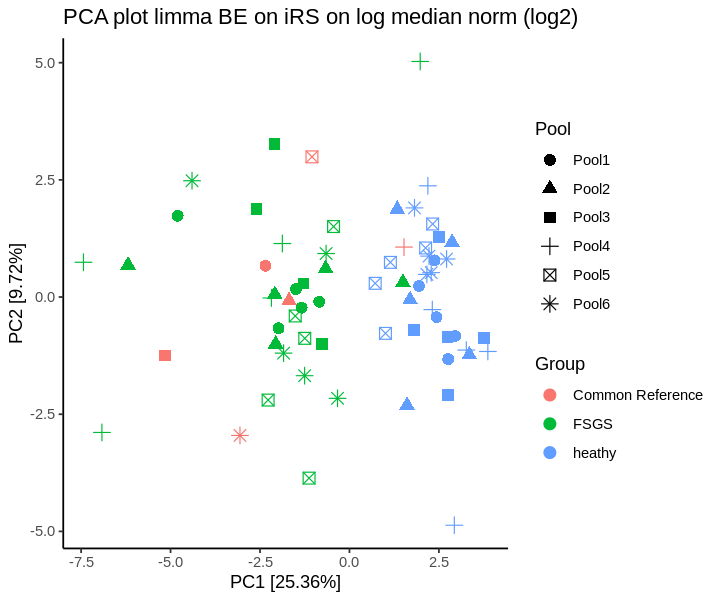

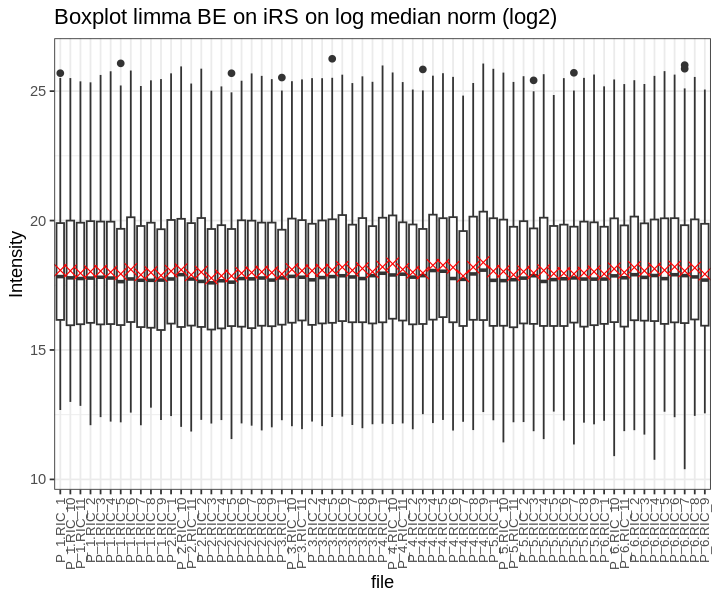

In [41]:
limma_on_irs_on_log_median <- limma::removeBatchEffect(log2(irs_on_log_median[, -c("Majority.protein.IDs", "Gene.names")]), batch, design = design)
# add back the Majority.protein.IDs and Gene.names
limma_on_irs_on_log_median <- cbind(irs_on_log_median[, c("Majority.protein.IDs", "Gene.names")], limma_on_irs_on_log_median)

# plot PCA
pca_plot(limma_on_irs_on_log_median[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on iRS on log median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(limma_on_irs_on_log_median[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot limma BE on iRS on log median norm (log2)", "")

## on log_median_on_irs

Warning message:
“Partial NA coefficients for 26 probe(s)”
Warning message:
“Removed 436 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 436 rows containing non-finite values (`stat_summary()`).”


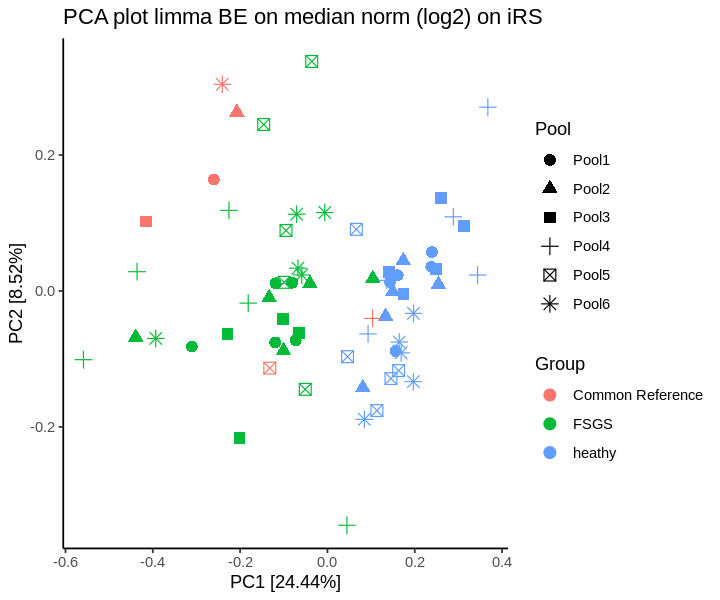

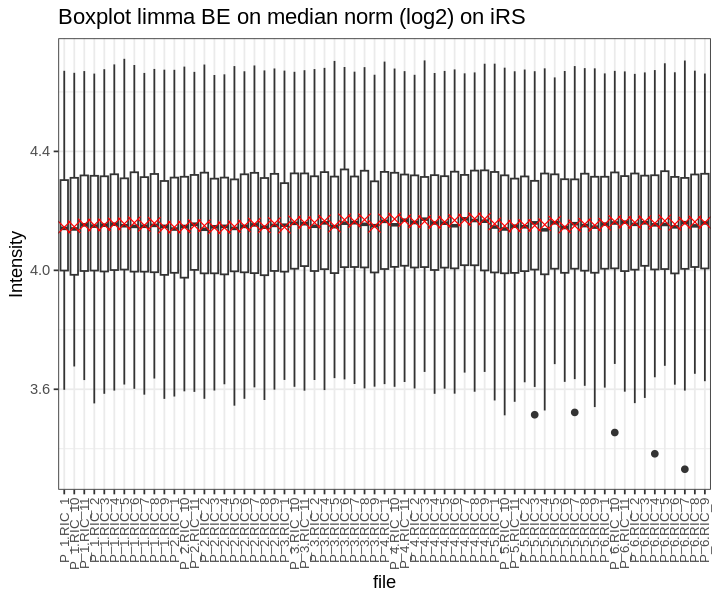

In [40]:
## on log_median_on_irs data
limBE_on_log_median_on_irs <- limma::removeBatchEffect(log2(log_median_on_irs[, -c("Majority.protein.IDs", "Gene.names")]), batch, design = design)
# add back the Majority.protein.IDs and Gene.names
limBE_on_log_median_on_irs <- cbind(log_median_on_irs[, c("Majority.protein.IDs", "Gene.names")], limBE_on_log_median_on_irs)

# plot PCA
pca_plot(limBE_on_log_median_on_irs[, -c("Majority.protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on median norm (log2) on iRS", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(limBE_on_log_median_on_irs[, -c("Majority.protein.IDs", "Gene.names")], "Boxplot limma BE on median norm (log2) on iRS", "")

# The results into DE analysis

- on corrected data w/o covariates - on limBE_on_irs_on_median
- on uncorrected data with covariates - on log2(irs_on_median)

In [484]:
library(ggrepel)

volcano_plot <- function(result, title) {
  result$P.Value.log <- -log10(result$adj.P.Val)

  volcano_plot <- ggplot(result, aes(x = logFC, y = P.Value.log, color = abs(logFC) > 0.25 & P.Value.log > -log10(0.05))) +
    # add name to the color legeng
    scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black"), 
                        name = "DE proteins") +
    # add line for p-value threshold (0.05) and logFC threshold (1)
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
    geom_vline(xintercept = c(-0.25, 0.25), linetype = "dashed") +
    geom_point() +
    theme_minimal() +
    xlab("Log Fold Change") +
    ylab("-log10 P-value") +
    ggtitle(paste0("Volcano plot for limma results, ", title)) +
    # add names for PG that passed the thresholds -- using rownames as labels
    geom_text_repel(data = result[result$adj.P.Val < 0.05 & abs(result$logFC) > 0.25,], 
                    aes(label = result[result$adj.P.Val < 0.05 & abs(result$logFC) > 0.25,]$Gene.names), 
                    size = 3) 

  return(volcano_plot)
}

## on corrected data

In [485]:
# remove the common references
dim(prot_data)

meta_wo_common_ref <- meta_data[meta_data$Group != "Common Reference"] %>% as.data.frame() %>%
    # mutate group to factor but healthy should be the first level
    mutate(Group = factor(Group, levels = c("heathy", "FSGS"))) %>%
    mutate(Pool = as.factor(Pool))

data_for_de <- limBE_on_irs_on_median %>% as.data.frame() %>% column_to_rownames("Majority.protein.IDs") %>% select(meta_wo_common_ref$Quantitative.column.name)
dim(data_for_de)


# DE analysis
design <- model.matrix(~0+meta_wo_common_ref$Group)
colnames(design) <- c(levels(meta_wo_common_ref$Group))

contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

fit <- lmFit(data_for_de, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_corrected <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
#add to results column with gene names using left_join by result rownames
results_corrected <- results_corrected %>% as.data.frame() %>% rownames_to_column("Majority.protein.IDs") %>% 
    left_join(select(prot_data, c("Majority.protein.IDs", "Gene.names")), by = "Majority.protein.IDs")

head(results_corrected)

[1] 264  67

[1] 264  59

,Majority.protein.IDs,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,Gene.names
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,A0A024R6N5;A0A0G2JRN3,0.07132551,-0.2822841,0.42493514,19.52482,0.4032854,6.881393e-01,7.633142e-01,-6.888113,
2,A0A075B6I9;P04211,-0.60265456,-0.8094617,-0.39584747,15.42867,-5.8263248,2.243739e-07,2.058260e-06,6.612174,IGLV7-46
3,A0A087WSY5;Q96IY4,-0.28715798,-0.3841672,-0.19014875,19.50910,-5.9183347,1.572884e-07,1.576063e-06,6.959059,CPB2
4,A0A087WT59;P02766,-0.03846184,-0.2011739,0.12425027,20.14197,-0.4726089,6.381680e-01,7.230745e-01,-6.857622,TTR
5,A0A087X0I0;A0A140T9L7;A0A140T8Z8;A0A140T9C0;A0A140T902;A0A140T8Y3;A0A140TA52;A0A140TA41;A0A140TA33;A0A3B3ISX9;P22105,-0.30989712,-0.3943646,-0.22542962,18.32116,-7.3353287,5.935155e-10,2.238401e-08,12.428791,TNXB
6,A0A087X0M8;O00533,-0.13294643,-0.2196459,-0.04624694,18.21327,-3.0658564,3.224646e-03,7.739151e-03,-2.567077,CHL1


Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


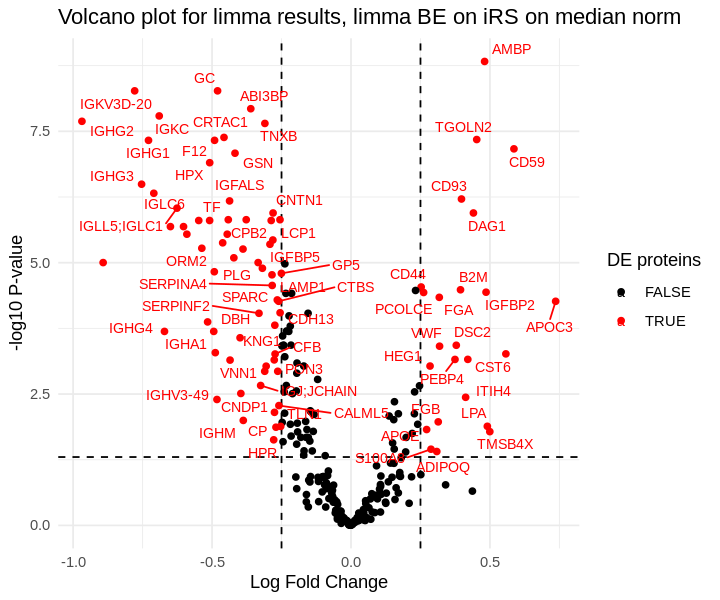

In [486]:
volcano_plot(results_corrected, "limma BE on iRS on median norm")

## on uncorrected data

In [487]:
# remove the common references
dim(prot_data)
data_for_de <- irs_on_median %>% as.data.frame() %>% column_to_rownames("Majority.protein.IDs") %>% select(meta_wo_common_ref$Quantitative.column.name) %>%
    log2()
dim(data_for_de)


# DE analysis
design <- model.matrix(~0+meta_wo_common_ref$Group+meta_wo_common_ref$Pool)
colnames(design) <- c(levels(meta_wo_common_ref$Group), levels(meta_wo_common_ref$Pool)[-1])

contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

fit <- lmFit(data_for_de, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_NOTcorrected <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
#add to results column with gene names using left_join by result rownames
results_NOTcorrected <- results_NOTcorrected %>% as.data.frame() %>% rownames_to_column("Majority.protein.IDs") %>% 
    left_join(select(prot_data, c("Majority.protein.IDs", "Gene.names")), by = "Majority.protein.IDs")

head(results_NOTcorrected)

[1] 264  67

[1] 264  59

Warning message:
“Partial NA coefficients for 26 probe(s)”


,Majority.protein.IDs,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,Gene.names
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,A0A024R6N5;A0A0G2JRN3,0.07246878,-0.2974163,0.44235386,19.51969,0.3924204,6.962271e-01,7.690542e-01,-6.849214,
2,A0A075B6I9;P04211,-0.60032013,-0.8157241,-0.38491617,15.41819,-5.5820874,7.071327e-07,6.222768e-06,5.547272,IGLV7-46
3,A0A087WSY5;Q96IY4,-0.28594003,-0.3871891,-0.18469096,19.50363,-5.6565459,5.365872e-07,4.984972e-06,5.816238,CPB2
4,A0A087WT59;P02766,-0.03667014,-0.2067454,0.13340515,20.13392,-0.4318558,6.674931e-01,7.466872e-01,-6.832879,TTR
5,A0A087X0I0;A0A140T9L7;A0A140T8Z8;A0A140T9C0;A0A140T902;A0A140T8Y3;A0A140TA52;A0A140TA41;A0A140TA33;A0A3B3ISX9;P22105,-0.31011269,-0.3987865,-0.22143889,18.32213,-7.0047336,3.289359e-09,1.240558e-07,10.801597,TNXB
6,A0A087X0M8;O00533,-0.13352514,-0.2229091,-0.04414118,18.21587,-2.9920636,4.105424e-03,1.003548e-02,-2.741490,CHL1


Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


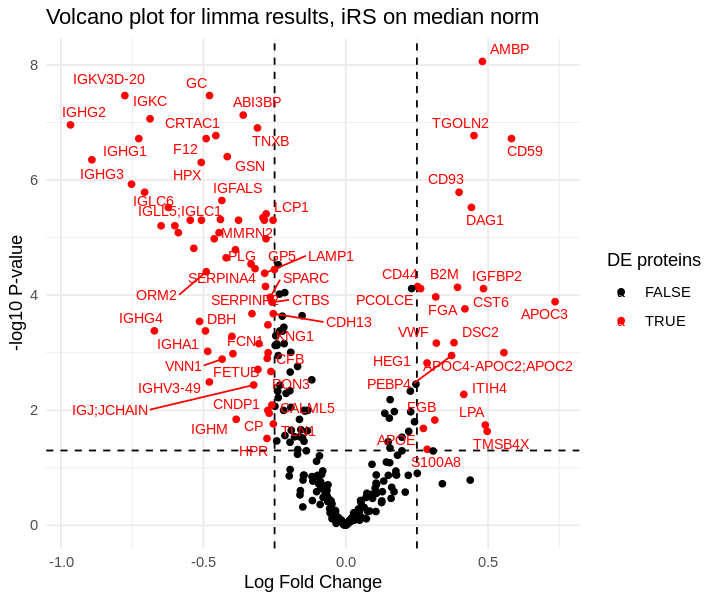

In [488]:
volcano_plot(results_NOTcorrected, "iRS on median norm")

In [490]:
print(results_NOTcorrected %>%
    filter(adj.P.Val < 0.05 & abs(logFC) > 0.25) %>%
    filter(Gene.names != "") %>% 
    select(Gene.names, logFC, adj.P.Val) %>%
    arrange(Gene.names)) %>%
    nrow()

           Gene.names      logFC    adj.P.Val
1              ABI3BP -0.3600785 7.425619e-08
2                AHSG -0.4202639 2.240924e-05
3                AMBP  0.4801488 8.681392e-09
4               APOC3  0.7354931 1.297544e-04
5   APOC4-APOC2;APOC2  0.5556818 9.974767e-04
6                APOE  0.2727486 2.069315e-02
7                 B2M  0.3927596 7.310922e-05
8              CALML5 -0.2594281 8.098164e-03
9                CD44  0.2523422 7.088977e-05
10               CD59  0.5822378 1.901670e-07
11               CD93  0.3981907 1.627971e-06
12              CDH13 -0.2545484 2.095233e-04
13                CFB -0.2728087 1.001248e-03
14              CNDP1 -0.2735899 1.004995e-02
15              CNTN1 -0.2795566 3.861298e-06
16                 CP -0.2690090 1.127727e-02
17               CPB2 -0.2859400 4.984972e-06
18             CRTAC1 -0.4563275 1.687458e-07
19               CST6  0.4187032 1.728124e-04
20               CTBS -0.2591121 1.325898e-04
21               DAG1  0.4415889 2

[1] 83

In [491]:
print(results_corrected %>%
    filter(adj.P.Val < 0.05 & abs(logFC) > 0.25) %>%
    filter(Gene.names != "") %>% 
    select(Gene.names, logFC, adj.P.Val) %>%
    arrange(Gene.names)) %>%
    nrow()

           Gene.names      logFC    adj.P.Val
1              ABI3BP -0.3606665 1.175138e-08
2              ADIPOQ  0.3086815 3.921906e-02
3                AHSG -0.4215709 8.076756e-06
4                AMBP  0.4808101 1.480505e-09
5               APOC3  0.7364464 5.431127e-05
6   APOC4-APOC2;APOC2  0.5573057 5.438354e-04
7                APOE  0.2721449 1.497694e-02
8                 B2M  0.3940956 3.278020e-05
9              CALML5 -0.2594058 5.242719e-03
10               CD44  0.2525250 2.901408e-05
11               CD59  0.5863457 6.819133e-08
12               CD93  0.3975297 6.141878e-07
13              CDH13 -0.2551455 8.971409e-05
14                CFB -0.2731901 5.468970e-04
15              CNDP1 -0.2753352 7.049103e-03
16              CNTN1 -0.2804290 1.132542e-06
17                 CP -0.2700067 1.353065e-02
18               CPB2 -0.2871580 1.576063e-06
19             CRTAC1 -0.4570594 4.128767e-08
20               CST6  0.4203330 6.922288e-04
21               CTBS -0.2602923 5

[1] 84

In [493]:
list_corrected <- results_corrected %>%
    filter(adj.P.Val < 0.05 & abs(logFC) > 0.25) %>%
    filter(Gene.names != "") %>% 
    select(Gene.names, logFC, adj.P.Val) %>%
    arrange(Gene.names) %>% 
    pull(Gene.names)

list_uncorrected <- results_NOTcorrected %>%
    filter(adj.P.Val < 0.05 & abs(logFC) > 0.25) %>%
    filter(Gene.names != "") %>% 
    select(Gene.names, logFC, adj.P.Val) %>%
    arrange(Gene.names) %>% 
    pull(Gene.names)

print(setdiff(list_corrected, list_uncorrected))    
print(setdiff(list_uncorrected, list_corrected))    

[1] "ADIPOQ"
character(0)


# Normalize and analyze only first center

In [455]:
metadata <- read.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Metadata_CosyBio.tsv",
                       header = TRUE, sep = "\t", stringsAsFactors = FALSE)
                       
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(".Pool", ".P_", gsub("Reporter.intensity.corrected.", "RIC_", Quantitative.column.name)))


# remove the outlier
metadata <- metadata %>%
            filter(Quantitative.column.name != "RIC_3.P_3")


# rename the columns - put the .P_[1-9]+ after dot before and the rest after (e.g. RIC_1.P_1 -> P_1.RIC_1)
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub("RIC_([0-9]+).P_([0-9]+)", "P_\\2.RIC_\\1", Quantitative.column.name))


head(metadata, 3)
dim(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
Reporter.intensity.corrected.3.Pool1,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1


[1] 65  6

[1] "Center1"
[1] 500


[1] 500  24

Warning message:
“Partial NA coefficients for 39 probe(s)”


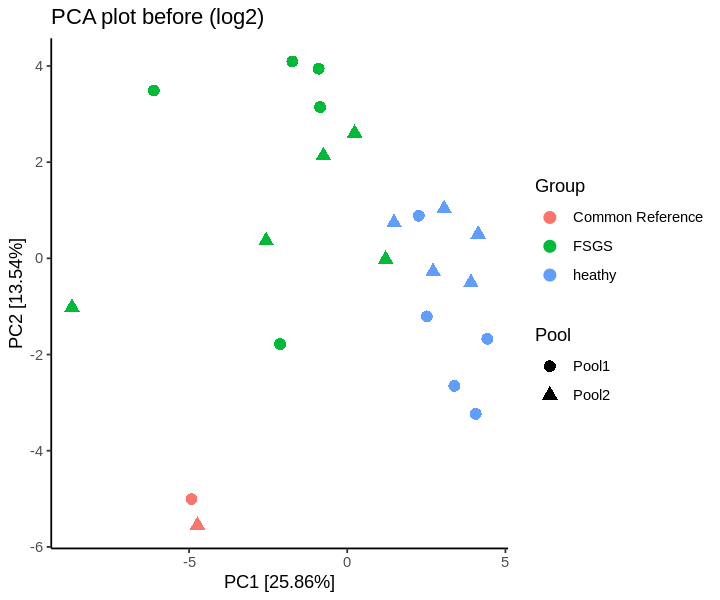

In [456]:
# Normalize and analyze only first center
center1_metadata <- metadata %>%
    filter(Center == "Center1")

pror_center_1 <- preprocess_mxout(list_of_outputs[["Center1"]], center1_metadata, "Center1")[[1]]
pror_center_1 <- pror_center_1[, c("Majority.protein.IDs", "Gene.names", rownames(center1_metadata))]
colnames(pror_center_1) <- c("Majority.protein.IDs", "Gene.names", center1_metadata$Quantitative.column.name)
dim(pror_center_1)

rownames(center1_metadata) <- center1_metadata$Quantitative.column.name

pror_center_1 <- pror_center_1 %>% as.data.table()
center1_metadata <- center1_metadata %>% as.data.table()

# replace zeros with NAs in numerical columns:
# Replace all 0s with NAs in specified columns of prot_data
pror_center_1[, (center1_metadata$Quantitative.column.name) := lapply(.SD, function(x) { ifelse(x == 0, NA, x) }), .SDcols = center1_metadata$Quantitative.column.name]
pror_center_1 <- filter_na_proteins(pror_center_1, center1_metadata) 

# median normalization
median_center1 <- medianNorm(pror_center_1[, -c("Majority.protein.IDs", "Gene.names")], center1_metadata)
# return the data to the original format
median_center1 <- cbind(pror_center_1[, c("Majority.protein.IDs", "Gene.names")], median_center1)

# irs normalization
irs_center1 <- irsNorm(median_center1[,-c("Majority.protein.IDs", "Gene.names")], center1_metadata, 
        center1_metadata$Pool,
        center1_metadata[center1_metadata$Group == "Common Reference",]$Quantitative.column.name)
# return the data to the original format
irs_center1 <- cbind(median_center1[, c("Majority.protein.IDs", "Gene.names")], irs_center1)


# limma BE
design <- model.matrix(~0 + center1_metadata$Group)
batch <- center1_metadata$Pool

limBE_center1 <- limma::removeBatchEffect(log2(irs_center1[, -c("Majority.protein.IDs", "Gene.names")]), batch, design = design)
limBE_center1 <- cbind(median_center1[, c("Majority.protein.IDs", "Gene.names")], limBE_center1)


# PCA plot
pca_plot(limBE_center1[,-c("Majority.protein.IDs", "Gene.names")], center1_metadata, "PCA plot before (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")




In [457]:
# analysis on corrected
# remove the common references
dim(limBE_center1)

meta_wo_common_ref <- center1_metadata[center1_metadata$Group != "Common Reference"] %>% as.data.frame() %>%
    # mutate group to factor but healthy should be the first level
    mutate(Group = factor(Group, levels = c("heathy", "FSGS"))) %>%
    mutate(Pool = as.factor(Pool))

data_for_de <- limBE_center1 %>% as.data.frame() %>% column_to_rownames("Majority.protein.IDs") %>% select(meta_wo_common_ref$Quantitative.column.name)
dim(data_for_de)


# DE analysis
design <- model.matrix(~0+meta_wo_common_ref$Group)
colnames(design) <- c(levels(meta_wo_common_ref$Group))

contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

fit <- lmFit(data_for_de, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_corrected <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
#add to results column with gene names using left_join by result rownames
results_corrected <- results_corrected %>% as.data.frame() %>% rownames_to_column("Majority.protein.IDs") %>% 
    left_join(select(prot_data, c("Majority.protein.IDs", "Gene.names")), by = "Majority.protein.IDs")

head(results_corrected)


[1] 499  24

[1] 499  20

,Majority.protein.IDs,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,Gene.names
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,A0A024R6N5;A0A0G2JRN3,0.09338108,-0.04784953,0.23461169,20.08012,1.3729690,0.183893359,0.31425612,-5.655713,
2,A0A075B6I0,-0.28346504,-0.92300312,0.35607305,13.02129,-0.9203728,0.367575473,0.52898843,-6.156297,NA
3,A0A075B6I9;P04211,-0.57591216,-0.99042198,-0.16140234,13.77291,-2.8850418,0.008715687,0.03990026,-2.982144,IGLV7-46
4,A0A075B6K4,-0.24767133,-0.60864946,0.11330680,14.32303,-1.4247069,0.168576220,0.29515626,-5.587709,NA
5,A0A075B6P5;A0A087WW87;P01615;P01614;A2NJV5;A0A0A0MRZ7;A0A075B6S6;A0A075B6S2;P06310,-0.47900681,-0.80327722,-0.15473641,15.83826,-3.0673623,0.005733062,0.03214380,-2.590477,NA
6,A0A087WSY5;Q96IY4,-0.10897093,-0.26337540,0.04543354,17.38775,-1.4654853,0.157240291,0.28122905,-5.532652,CPB2


Warning message:
“Removed 53 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


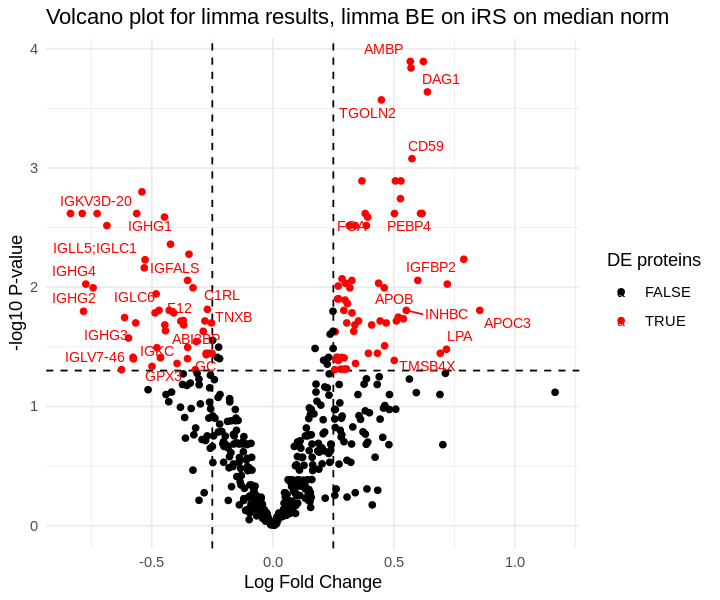

In [458]:
volcano_plot(results_corrected, "limma BE on iRS on median norm")

In [459]:
# remove the common references
dim(irs_center1)
data_for_de <- irs_center1 %>% as.data.frame() %>% column_to_rownames("Majority.protein.IDs") %>% select(meta_wo_common_ref$Quantitative.column.name) %>%
    log2()
dim(data_for_de)


# DE analysis
design <- model.matrix(~0+meta_wo_common_ref$Group+meta_wo_common_ref$Pool)
colnames(design) <- c(levels(meta_wo_common_ref$Group), levels(meta_wo_common_ref$Pool)[-1])

contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

fit <- lmFit(data_for_de, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_NOTcorrected <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
#add to results column with gene names using left_join by result rownames
results_NOTcorrected <- results_NOTcorrected %>% as.data.frame() %>% rownames_to_column("Majority.protein.IDs") %>% 
    left_join(select(prot_data, c("Majority.protein.IDs", "Gene.names")), by = "Majority.protein.IDs")

head(results_NOTcorrected)

[1] 499  24

[1] 499  20

Warning message:
“Partial NA coefficients for 39 probe(s)”


,Majority.protein.IDs,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,Gene.names
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,A0A024R6N5;A0A0G2JRN3,0.09338108,-0.05288224,0.23964440,20.08012,1.329501,0.198255378,0.33832073,-5.681561,
2,A0A075B6I0,-0.28346504,-0.93889119,0.37196111,13.02129,-0.900619,0.378226023,0.54234134,-6.143532,NA
3,A0A075B6I9;P04211,-0.57591216,-1.00114104,-0.15068328,13.77291,-2.820323,0.010391403,0.04508965,-3.109641,IGLV7-46
4,A0A075B6K4,-0.24767133,-0.61700525,0.12166259,14.32303,-1.396439,0.177486172,0.31185070,-5.595729,NA
5,A0A075B6P5;A0A087WW87;P01615;P01614;A2NJV5;A0A0A0MRZ7;A0A075B6S6;A0A075B6S2;P06310,-0.47900681,-0.81239477,-0.14561886,15.83826,-2.991969,0.007060697,0.03708724,-2.749328,NA
6,A0A087WSY5;Q96IY4,-0.10897093,-0.26873202,0.05079016,17.38775,-1.420381,0.170493627,0.30276270,-5.564185,CPB2


Warning message:
“Removed 55 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


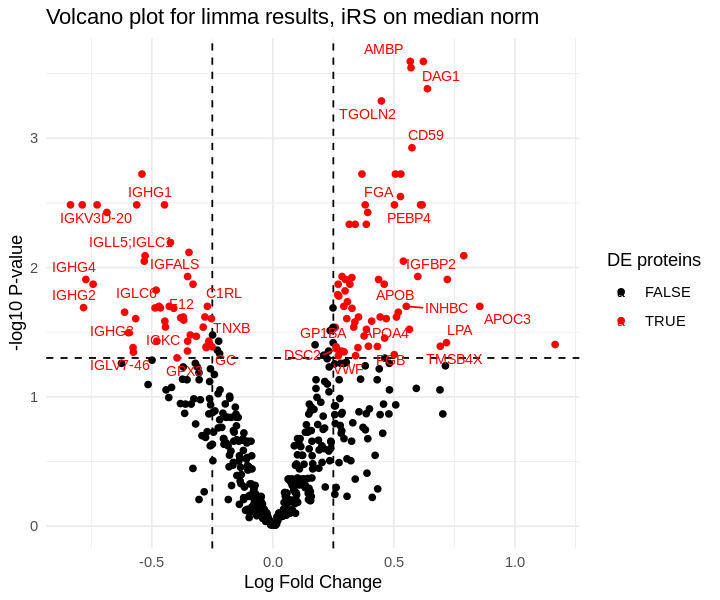

In [460]:
volcano_plot(results_NOTcorrected, "iRS on median norm")

In [462]:
print(results_corrected %>%
    filter(adj.P.Val < 0.05 & abs(logFC) > 0.25) %>%
    filter(Gene.names != "") %>% 
    select(Gene.names, logFC, adj.P.Val) %>%
    arrange(Gene.names))

    Gene.names      logFC    adj.P.Val
1       ABI3BP -0.2875381 0.0233930874
2         AMBP  0.5678304 0.0001277165
3      ANGPTL3  0.5183280 0.0177932739
4        APOA4  0.3950528 0.0357885041
5         APOB  0.4601699 0.0101112324
6        APOC3  0.8549752 0.0156221717
7          B2M  0.3388581 0.0207087474
8         C1RL -0.2704111 0.0153129062
9        C4BPA  0.3264311 0.0087652600
10       C4BPB  0.2934266 0.0156221717
11        CD44  0.2679105 0.0125146406
12        CD59  0.5747851 0.0008346725
13        CD93  0.3183299 0.0101112324
14        CETP  0.4684406 0.0199234525
15        CST3  0.3342382 0.0233930874
16        DAG1  0.6386701 0.0002300138
17        DSC2  0.2646980 0.0385766546
18        ECM1 -0.3525969 0.0397107269
19         F12 -0.3698809 0.0190164726
20        F13B  0.2859571 0.0084950181
21        FCN2  0.3417292 0.0435621163
22         FGA  0.3816988 0.0024063085
23         FGB  0.4320365 0.0357885041
24          GC -0.2753430 0.0357886469
25       GP1BA  0.2613953